<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Regression---Stacking,--the-principle" data-toc-modified-id="Regression---Stacking,--the-principle-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression - Stacking,  the principle</a></span></li><li><span><a href="#Stacking-SKlearn-Implementation" data-toc-modified-id="Stacking-SKlearn-Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Stacking SKlearn Implementation</a></span><ul class="toc-item"><li><span><a href="#Create-a-dummy/baseline" data-toc-modified-id="Create-a-dummy/baseline-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create a dummy/baseline</a></span></li></ul></li><li><span><a href="#What-goes-on-under-the-hood" data-toc-modified-id="What-goes-on-under-the-hood-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>What goes on under the hood</a></span></li><li><span><a href="#More-complex-case" data-toc-modified-id="More-complex-case-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>More complex case</a></span><ul class="toc-item"><li><span><a href="#Is-there-a-transformation-possible-to-find-a-more-linear-relationship?" data-toc-modified-id="Is-there-a-transformation-possible-to-find-a-more-linear-relationship?-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Is there a transformation possible to find a more linear relationship?</a></span></li></ul></li><li><span><a href="#Investigate-Stacking" data-toc-modified-id="Investigate-Stacking-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Investigate Stacking</a></span></li><li><span><a href="#Possible-solution" data-toc-modified-id="Possible-solution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Possible solution</a></span></li><li><span><a href="#Does-stacking-always-beat-a-plain-model?" data-toc-modified-id="Does-stacking-always-beat-a-plain-model?-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Does stacking always beat a plain model?</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Purpose

**CODE-ALONGS**
1. Create a collaborative learning environment
2. Get inspired to explore beyond the mainstream solutions

**TODAY HIGHLEVEL**
1. Calibrating the level that works
2. Identifying subjects that work

**TODAY - This exercise**
1. Demo and practice/explore Stacking. Sklearn implementation
2. What goes on behind the scenes

**small print**
- Demonstrate stacking:
    - not showcasing good data science
    - Excludes CV, Gridsearching, data wrangling, feature engineering etc.



## Regression - Stacking,  the principle 

Stacking is the concept to fit the strengths of different regressors to make even a better fit:


![](https://burakhimmetoglu.files.wordpress.com/2016/12/models.png)

This can be made very complex: gridsearch, cross val, nested cross val... all work.

**Warning:** 'Tuning for Kaggle' is different from 'tuning for production': Having imputed NaN's by a model prediction, preprocessed all the variables extensively, random gridsearched every model and then gridsearching the stacker may deliver a good R2 but also a blackbox.

http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/#example-2-stacked-regression-and-gridsearch

## Stacking SKlearn Implementation

In [1]:
#Import a load of packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
# create data sets for regression from diabetes dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets


def regression():
    data_regression = datasets.load_diabetes()
    df = pd.DataFrame(data_regression['data'],
                      columns=data_regression['feature_names'])
    df['ycol'] = data_regression['target']
    X = df.drop('ycol', axis=1)
    y = df['ycol'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=0)
    ss = StandardScaler()
    X_train = (ss.fit_transform(X_train))
    X_test = ss.transform(X_test)
    X = pd.DataFrame(ss.transform(X), columns=df.drop('ycol', axis=1).columns)
    print('Diabetes Dataset Data has been created for Regression ML')
    print(f'Shape df {df.shape}')
    print(f'Shape X {X.shape}')
    print(f'Shape y {y.shape}')
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape y_train {y_train.shape}')
    print(f'Shape X_test {X_test.shape}')
    print(f'Shape y_test {y_test.shape}')
    print(f'Mean X {X_train.mean()}, should be close to 0')
    print(f'Std X {X_train.std()}, should be close to 1')
    print(f'Available columns in df {df.columns.values}')
    return df, X, y, X_train, y_train, X_test, y_test

In [3]:
df, X, y, X_train, y_train, X_test, y_test = regression()

Diabetes Dataset Data has been created for Regression ML
Shape df (442, 11)
Shape X (442, 10)
Shape y (442,)
Shape X_train (296, 10)
Shape y_train (296,)
Shape X_test (146, 10)
Shape y_test (146,)
Mean X -6.901386369291514e-18, should be close to 0
Std X 1.0, should be close to 1
Available columns in df ['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6' 'ycol']


### Create a dummy/baseline

In [4]:
from sklearn.dummy import DummyRegressor
dummy = DummyRegressor(strategy='mean') 
dummy.fit(X_train,y_train)
print(f"The dummy's R squared = {round(dummy.score(X_test ,y_test),3)}")
#showing it will always predict the mean y
print('\n')
print(f'mean y: {np.mean(y_train)}') #scaled on X_train
dummy.predict(X)[:2]

The dummy's R squared = -0.001


mean y: 151.26351351351352


array([151.26351351, 151.26351351])

In [5]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor

#setting up the models and the  stacker

lr = LinearRegression()
knn = KNeighborsRegressor()
ridge = Ridge(random_state=1)
rfr = RandomForestRegressor(n_estimators=100,n_jobs=-1)

stack = StackingRegressor(regressors=[knn, lr, ridge], 
                           meta_regressor=rfr)

# Training the stacking regressor

stack.fit(X_train, y_train)
predictions = stack.predict(X_train)

# Evaluate and visualize the fit

print(f'Mean Squared Error: {np.mean((stack.predict(X_test) - y_test) ** 2)}')
print(f'R2 Stacker: {stack.score(X_train, y_train)}')

#compare to individual scores
#Cutting corners here: scoring on the train set to enable 1:1 comparison below

lr.fit(X_train,y_train)
lr_pred = lr.predict(X_train)
print(f'R2 linear reg: {lr.score(X_train, y_train)}')

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_train)
print(f'R2 knn reg: {knn.score(X_train, y_train)}')

ridge = ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_train)
print(f'R2 Ridge reg: {ridge.score(X_train, y_train)}')

Mean Squared Error: 3916.358273287671
R2 Stacker: 0.9379807298207895
R2 linear reg: 0.5590632525279866
R2 knn reg: 0.618363790865051
R2 Ridge reg: 0.5588460019795998


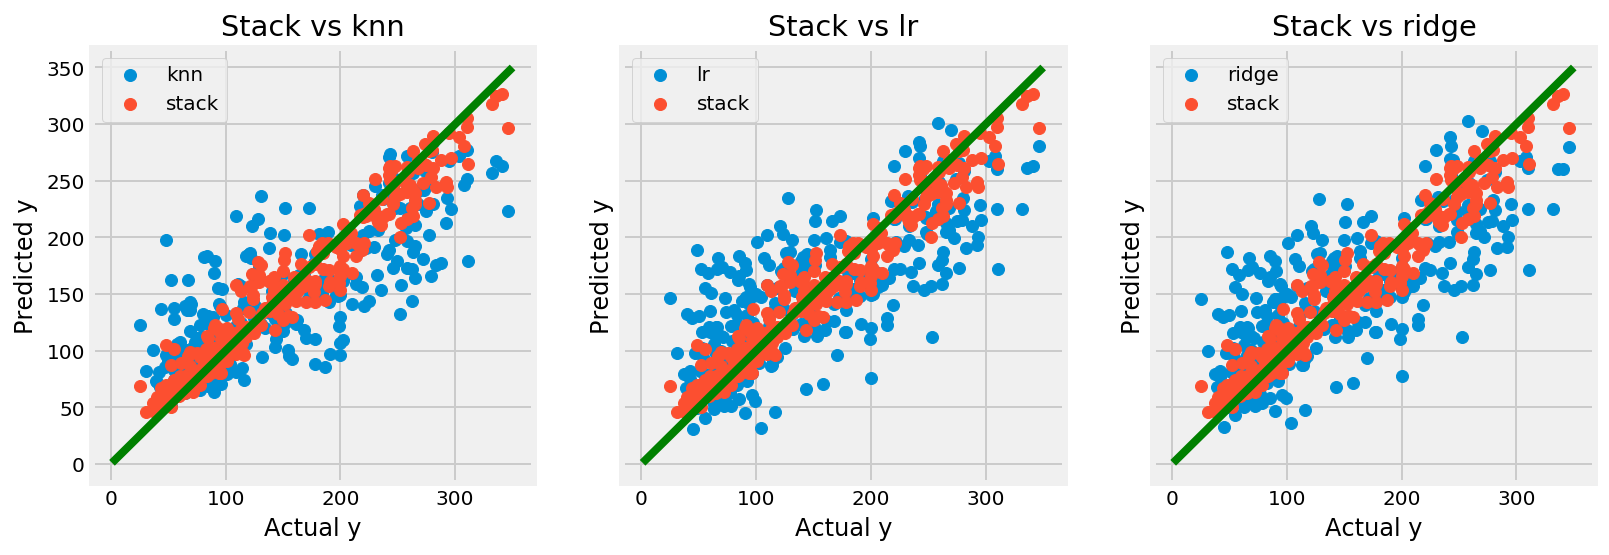

In [6]:
#plot

fig, (ax1, ax2, ax3) = plt.subplots(1,3 , sharey=True, figsize = (12,4))

ax1.point_1 = [1, 350]
ax1.plot(ax1.point_1, ax1.point_1, 'g')
ax1.scatter(y_train, knn_pred, label = 'knn')
ax1.scatter(y_train, predictions, label = 'stack')
ax1.set_title('Stack vs knn')
ax1.set_xlabel('Actual y')
ax1.set_ylabel('Predicted y')
ax1.legend()

ax2.point_1 = [1, 350]
ax2.plot(ax1.point_1, ax1.point_1, 'g')
ax2.scatter(y_train, lr_pred, label = 'lr', )
ax2.scatter(y_train, predictions, label = 'stack')
ax2.set_title('Stack vs lr')
ax2.set_xlabel('Actual y')
ax2.set_ylabel('Predicted y')
ax2.legend()

ax3.point_1 = [1, 350]
ax3.plot(ax1.point_1, ax1.point_1, 'g')
ax3.scatter(y_train, ridge_pred, label = 'ridge')
ax3.scatter(y_train, predictions, label = 'stack')
ax3.set_title('Stack vs ridge')
ax3.set_xlabel('Actual y')
ax3.set_ylabel('Predicted y')
ax3.legend()

plt.show()

## What goes on under the hood

In [7]:
# Create spearte dataset to compare
df_ = pd.DataFrame(X_train)

In [8]:
#df_ - dataframe with results of 3 regressors and true output e.g.

from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor

#setting up the models and the  stacker

lr = LinearRegression()
knn = KNeighborsRegressor()
ridge = Ridge(random_state=1)
rfr = RandomForestRegressor(n_estimators=100,n_jobs=-1)

#df_ = pd.DataFrame()

lr.fit(X_train,y_train)
df_['lr_pred'] = lr.predict(X_train)
print(f'R2 linear reg: {lr.score(X_train, y_train)}')

knn.fit(X_train, y_train)
df_['knn_pred'] = knn.predict(X_train)
print(f'R2 knn reg: {knn.score(X_train, y_train)}')

ridge.fit(X_train, y_train)
df_['ridge_pred'] = ridge.predict(X_train)
print(f'R2 Ridge reg: {ridge.score(X_train, y_train)}')

#Training the stacking regressor

#stacker= LinearRegression() #Toggle to see the difference
stacker= RandomForestRegressor(n_estimators=1000,n_jobs=-1)

stacker.fit(df_[['lr_pred', 'knn_pred', 'ridge_pred']], y_train)

df_['stack_pred'] = stacker.predict(df_[['lr_pred', 'knn_pred', 'ridge_pred']])

# # # Evaluate and visualize the fit

print('R2 Stacker:')
print(stacker.score(df_[['lr_pred', 'knn_pred', 'ridge_pred']], y_train))
print(np.mean((df_['stack_pred'] - y_train) ** 2))

R2 linear reg: 0.5590632525279866
R2 knn reg: 0.618363790865051
R2 Ridge reg: 0.5588460019795998
R2 Stacker:
0.9398713221435067
376.040576016892


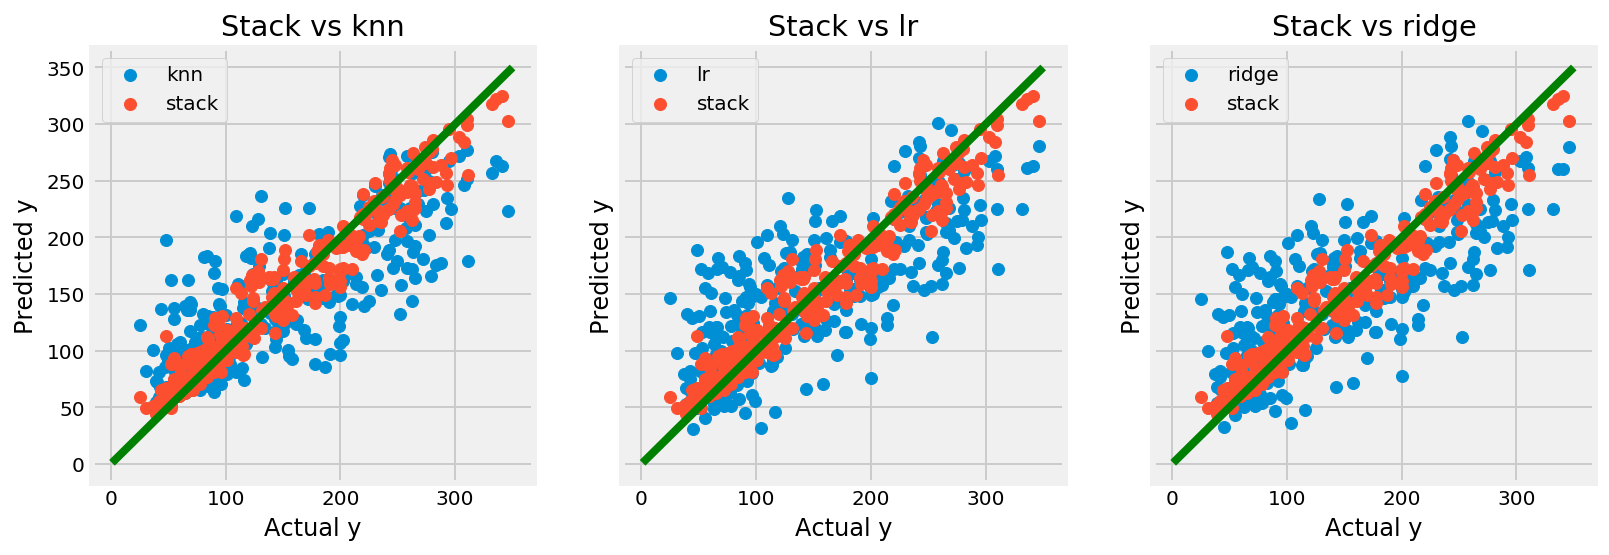

In [9]:
#plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3 , sharey=True, figsize = (12,4))

ax1.point_1 = [1, 350]
ax1.plot(ax1.point_1, ax1.point_1, 'g')
ax1.scatter(y_train, df_['knn_pred'], label = 'knn')
ax1.scatter(y_train, df_['stack_pred'], label = 'stack')
ax1.set_title('Stack vs knn')
ax1.set_xlabel('Actual y')
ax1.set_ylabel('Predicted y')
ax1.legend()

ax2.point_1 = [1, 350]
ax2.plot(ax1.point_1, ax1.point_1, 'g')
ax2.scatter(y_train, df_['lr_pred'], label = 'lr')
ax2.scatter(y_train, df_['stack_pred'], label = 'stack')
ax2.set_title('Stack vs lr')
ax2.set_xlabel('Actual y')
ax2.set_ylabel('Predicted y')
ax2.legend()

ax3.point_1 = [1, 350]
ax3.plot(ax1.point_1, ax1.point_1, 'g')
ax3.scatter(y_train, df_['ridge_pred'], label = 'ridge')
ax3.scatter(y_train, df_['stack_pred'], label = 'stack')
ax3.set_title('Stack vs ridge')
ax3.set_xlabel('Actual y')
ax3.set_ylabel('Predicted y')
ax3.legend()

plt.show()

## More complex case

Non-linear data

In [10]:
data = pd.read_csv('CodeAlongAuto.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA,ford torino


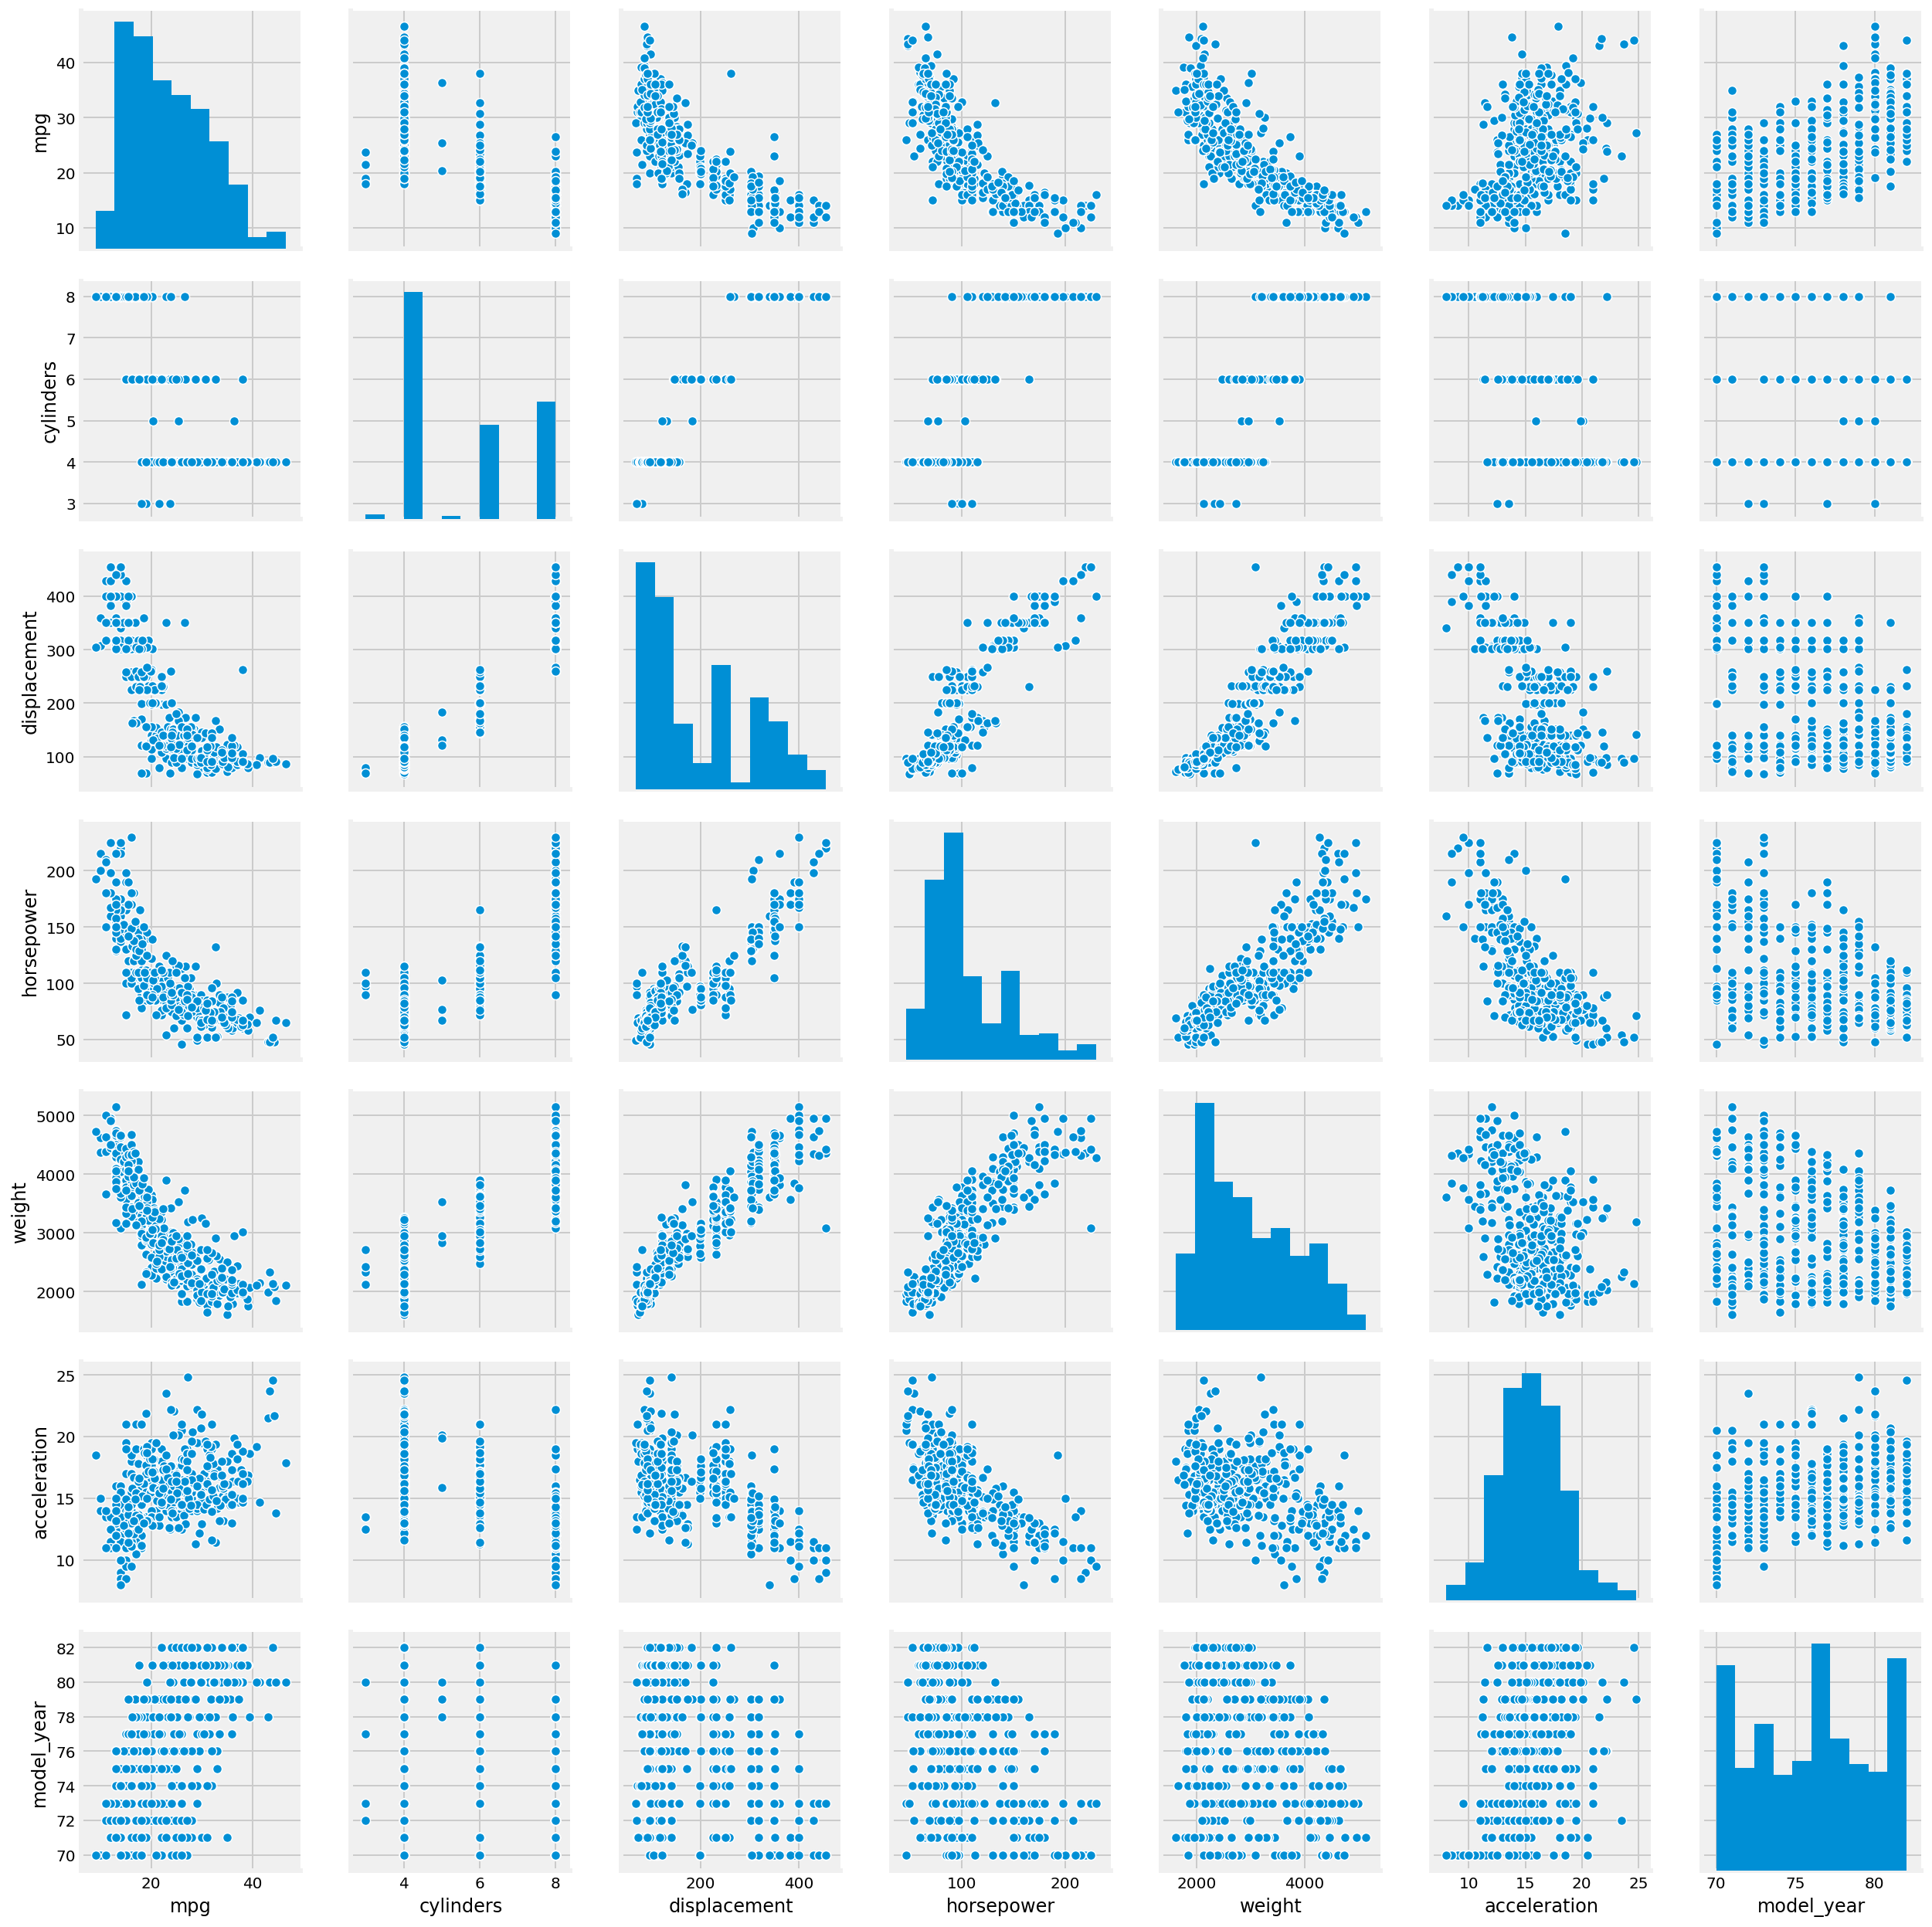

In [11]:
sns.pairplot(data);

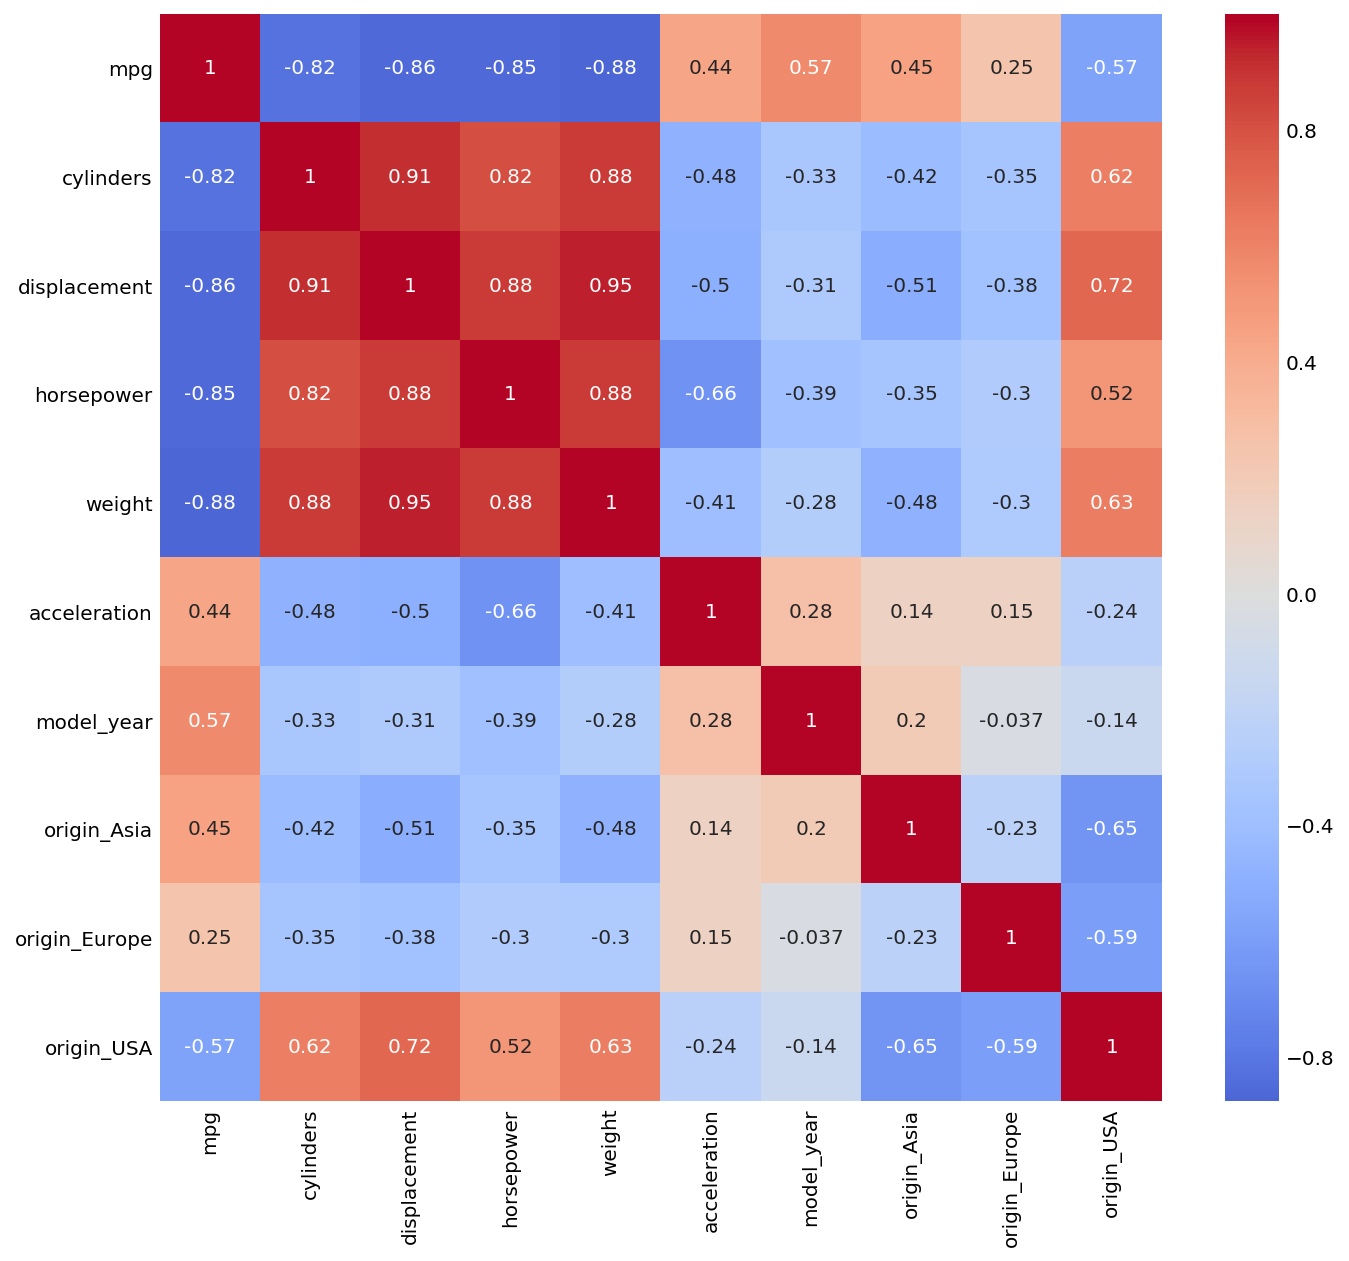

In [12]:
#make a correlation heatmap using Spearman's correlation
with_dummies = pd.get_dummies(data.iloc[:,:-1])
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(with_dummies.corr(method='spearman'), cmap='coolwarm', center=0, annot=True)
plt.yticks(rotation=0);

### Is there a transformation possible to find a more linear relationship? 

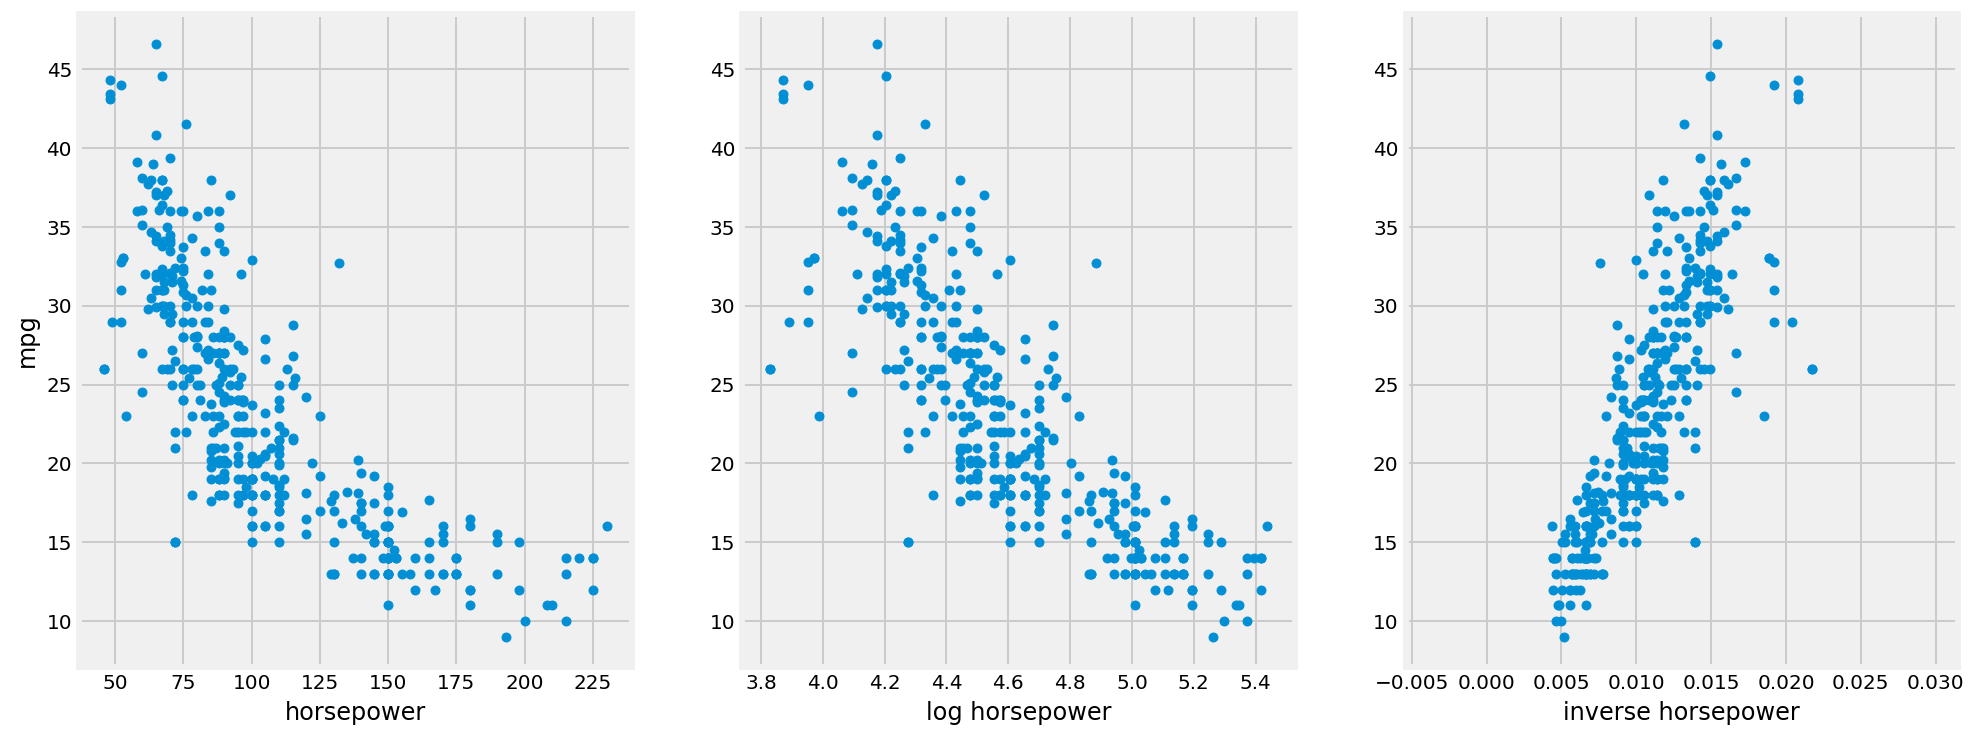

In [13]:
#now investigate just the relationship between mpg and horsepower, log horsepower, and inverse horsepower:
fig, ax = plt.subplots(ncols=3, figsize=(15,6))
data.plot.scatter(x='horsepower',y='mpg', ax=ax[0])
ax[1].scatter(np.log(data['horsepower']), data['mpg'],20)
ax[1].set_xlabel('log horsepower')
ax[2].scatter(1/(data['horsepower']), data['mpg'],20)
ax[2].set_xlabel('inverse horsepower');

In [14]:
#create a train-test-split
from sklearn.model_selection import train_test_split
X = data.copy()[['horsepower']]
y = data['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1990)

## Investigate Stacking

In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet


lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
enet = ElasticNet()
rfr = RandomForestRegressor(n_estimators=100,n_jobs=-1)

stack = StackingRegressor(regressors=['???','???','???'], 
                           meta_regressor="???")

## Insert your code



## Possible solution

In [22]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet

#setting up the models and the  stacker

lr = LinearRegression()
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor()
enet = ElasticNet()
rfr = RandomForestRegressor(n_estimators=100,n_jobs=-1)

stack = StackingRegressor(regressors=[knn, enet, dtr, rfr], 
                           meta_regressor=lr)

# Training the stacking regressor

stack.fit(X_train, y_train)
predictions = stack.predict(X_train)

# Evaluate and visualize the fit

print(f'Mean Squared Error: {np.mean((stack.predict(X_test) - y_test) ** 2)}')
print(f'R2 Stacker: {stack.score(X_test, y_test)}')

#simple plot

# lr.fit(X_train,y_train)
# lr_pred = lr.predict(X_train)
# print(f'R2 linear reg: {lr.score(X_test, y_test)}')

enet.fit(X_train, y_train)
enet_pred = enet.predict(X_train)
print(f'R2 ElasticNet reg: {enet.score(X_test, y_test)}')

knn.fit(X_train, y_train)
knn_pred = knn.predict(X_train)
print(f'R2 knn reg: {knn.score(X_test, y_test)}')

dtr.fit(X_train, y_train)
dtr_pred = dtr.predict(X_train)
print(f'R2 dtree reg: {dtr.score(X_test, y_test)}')

Mean Squared Error: 20.02256998181885
R2 Stacker: 0.6615759491368225
R2 ElasticNet reg: 0.6067775739985497
R2 knn reg: 0.6596071172818959
R2 dtree reg: 0.6615759491368225


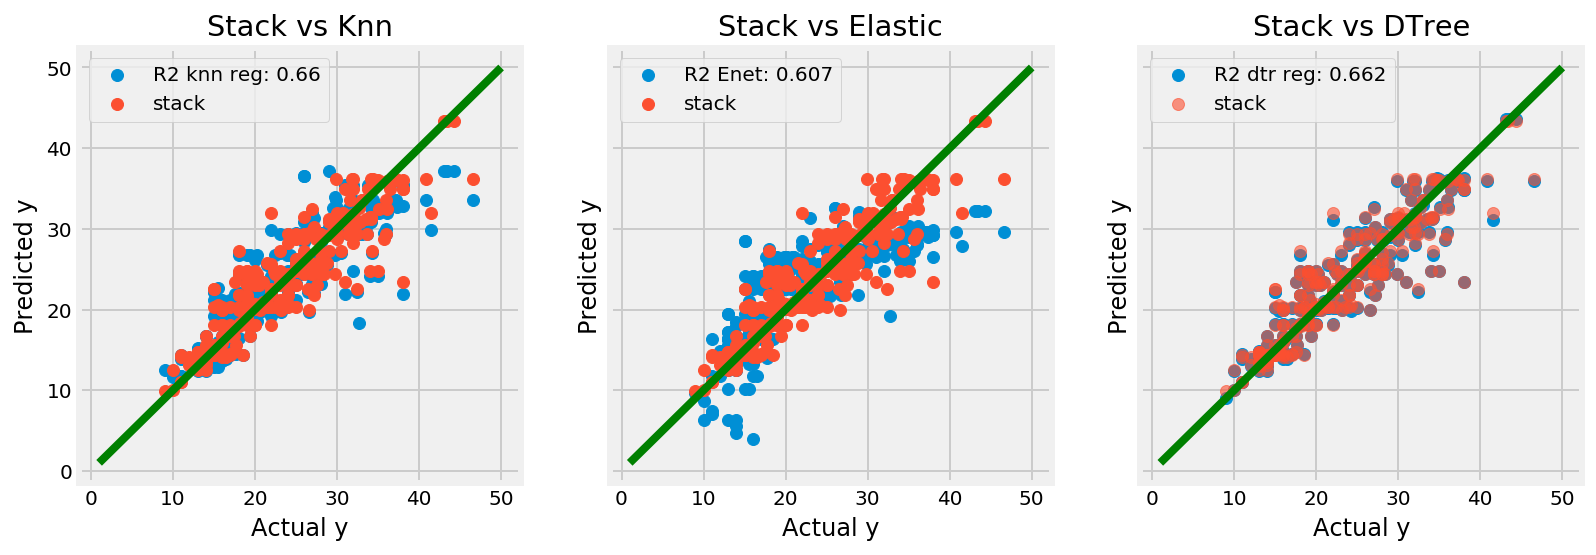

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3 , sharey=True, figsize = (12,4))

ax1.point_1 = [1, 50]
ax1.plot(ax1.point_1, ax1.point_1, 'g')
ax1.scatter(y_train, knn_pred, label = f'R2 knn reg: {round(knn.score(X_test, y_test),3)}')
ax1.scatter(y_train, predictions, label = 'stack')
ax1.set_title('Stack vs Knn')
ax1.set_xlabel('Actual y')
ax1.set_ylabel('Predicted y')
ax1.legend()

ax2.point_1 = [1, 50]
ax2.plot(ax1.point_1, ax1.point_1, 'g')
ax2.scatter(y_train, enet_pred, label = f'R2 Enet: {round(enet.score(X_test, y_test),3)}' )
ax2.scatter(y_train, predictions, label = 'stack')
ax2.set_title('Stack vs Elastic')
ax2.set_xlabel('Actual y')
ax2.set_ylabel('Predicted y')
ax2.legend()

ax3.point_1 = [1, 50]
ax3.plot(ax1.point_1, ax1.point_1, 'g')
ax3.scatter(y_train, dtr_pred, label = f'R2 dtr reg: {round(dtr.score(X_test, y_test),3)}')
ax3.scatter(y_train, predictions, label = 'stack',alpha=0.6)
ax3.set_title('Stack vs DTree')
ax3.set_xlabel('Actual y')
ax3.set_ylabel('Predicted y')
ax3.legend()

plt.show()

## Does stacking always beat a plain model?

In [17]:
#create a train-test-split, just using horsepower and mpg again
X = data.copy()[['horsepower']]
y = data['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1990)

R2 rfr_stubby: 0.7023637955987362
R2 rfr_middle: 0.6936634951358379
R2 rfr_deep: 0.6637813395682082
R2 Stacker: 0.6576987643203169


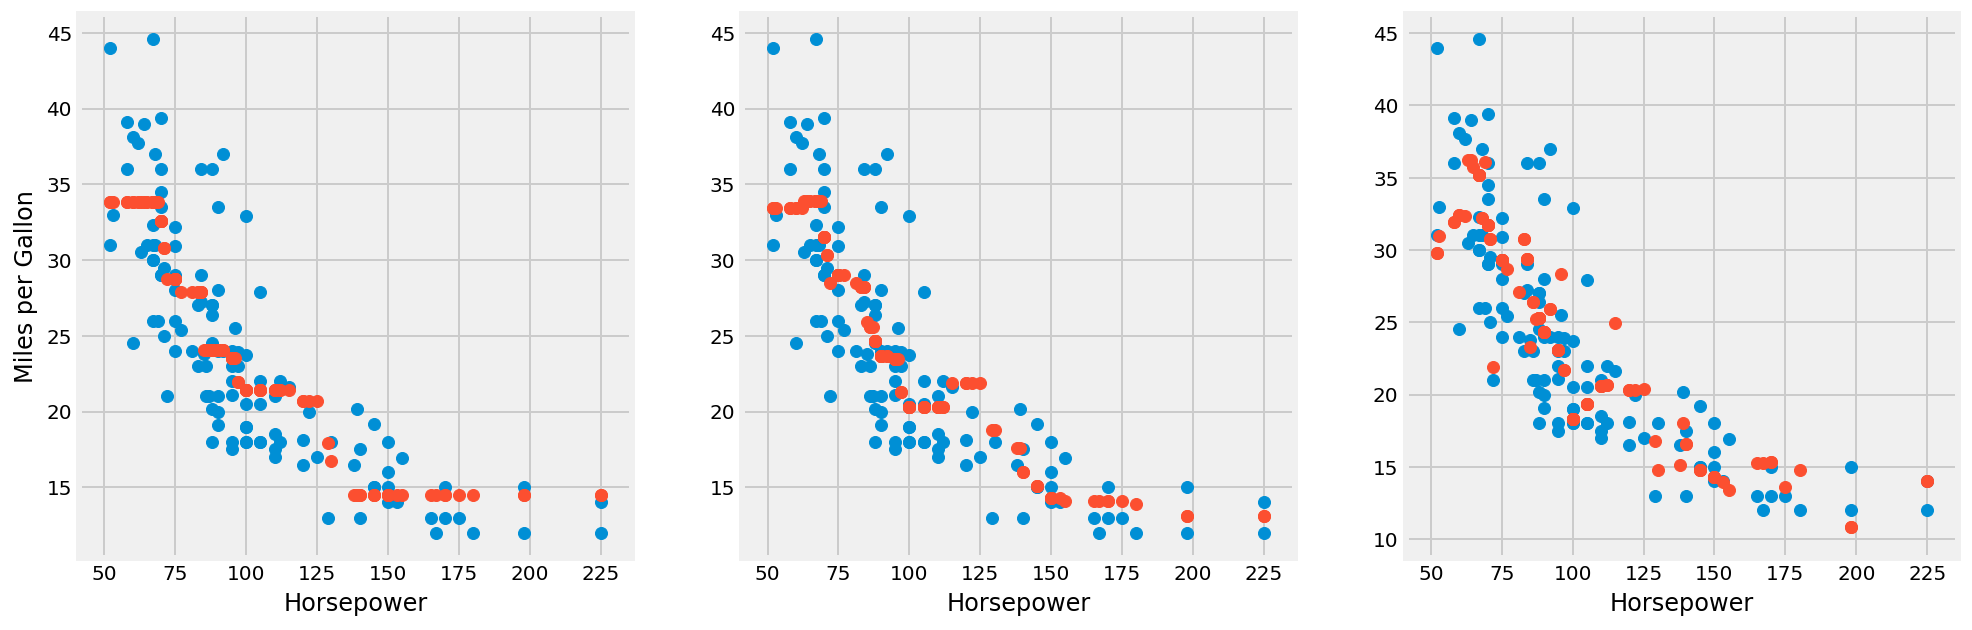

In [18]:
#let's compare how the depth of the tree impacts the predictions in a Random Forest model
rfr_stubby = RandomForestRegressor(max_depth=2)
rfr_middle = RandomForestRegressor(max_depth=3)
rfr_deep = RandomForestRegressor(max_depth=10)


fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].scatter(X_test['horsepower'], y_test, label='Test Data')
    ax[i].set_xlabel('Horsepower')
ax[0].set_ylabel('Miles per Gallon');

for i, rfr_model in enumerate([rfr_stubby, rfr_middle, rfr_deep]):
    rfr_model.fit(X_train,y_train)
    predictions = rfr_model.predict(X_test)
    ax[i].scatter(X_test['horsepower'], predictions)
    
print(f'R2 rfr_stubby: {rfr_stubby.score(X_test, y_test)}')
print(f'R2 rfr_middle: {rfr_middle.score(X_test, y_test)}')
print(f'R2 rfr_deep: {rfr_deep.score(X_test, y_test)}')
print(f'R2 Stacker: {stack.score(X_test, y_test)}')

R2 knn_smalln: 0.5807828091417695
R2 knn_middlen: 0.681694564168192
R2 knn_largen: 0.6418092739395969
R2 Stacker: 0.6576987643203169


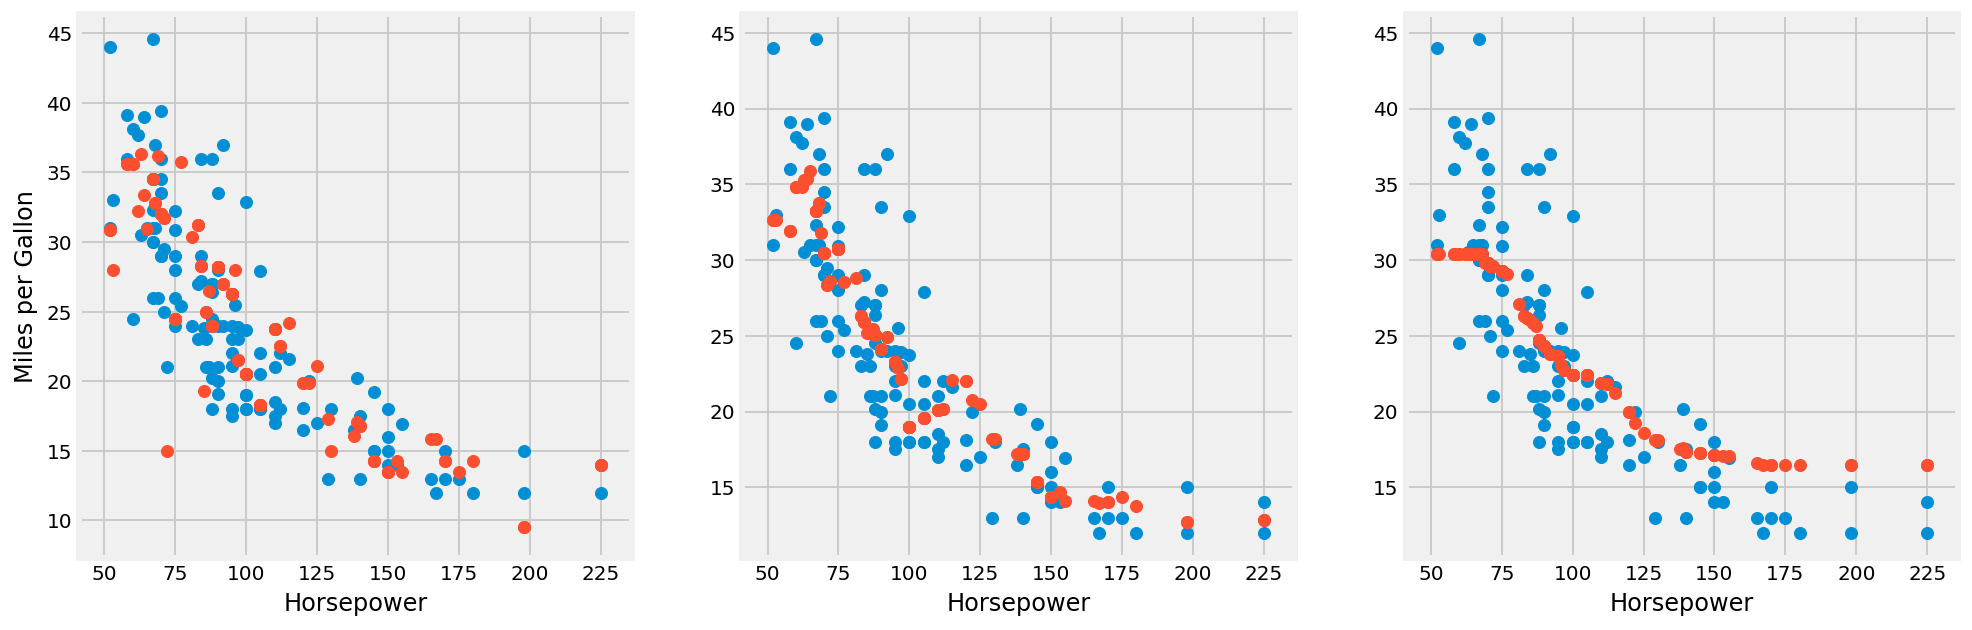

In [19]:
# let's compare how the number of neighbors affects the predictions in a KNN model
knn_smalln = KNeighborsRegressor(n_neighbors=2, weights='uniform')
knn_middlen = KNeighborsRegressor(n_neighbors=15, weights='uniform')
knn_largen = KNeighborsRegressor(n_neighbors=100, weights='uniform')


fig, ax = plt.subplots(ncols=3, figsize=(15,5))
for i in range(3):
    ax[i].scatter(X_test['horsepower'], y_test, label='Test Data')
    ax[i].set_xlabel('Horsepower')
ax[0].set_ylabel('Miles per Gallon');

for i, knn_model in enumerate([knn_smalln, knn_middlen, knn_largen]):
    knn_model.fit(X_train,y_train)
    predictions = knn_model.predict(X_test)
    ax[i].scatter(X_test['horsepower'], predictions)
    
print(f'R2 knn_smalln: {knn_smalln.score(X_test, y_test)}')
print(f'R2 knn_middlen: {knn_middlen.score(X_test, y_test)}')
print(f'R2 knn_largen: {knn_largen.score(X_test, y_test)}')
print(f'R2 Stacker: {stack.score(X_test, y_test)}')

## Conclusion

- Understand the principle of stacking
- Covered the Sklearn implementation, demo-ed what goes on under the hood
- Whether it works heavily depends on the dataset